<a href="https://colab.research.google.com/github/Akage1234/Pytorch-mini-projects/blob/main/NLP/LSTM_GRU/Fake_News_classification_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("using device:",device)

using device: cuda


In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

1. Loading the Dataset

In [4]:
from datasets import load_dataset
dataset = load_dataset('davanstrien/WELFake')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-290868f0a36350(…):   0%|          | 0.00/152M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/72134 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label'],
        num_rows: 72134
    })
})

In [6]:
def fix_none(batch):
    batch['text'] = [x if x is not None else "" for x in batch['text']]
    return batch

dataset = dataset.map(fix_none, batched=True)

Map:   0%|          | 0/72134 [00:00<?, ? examples/s]

In [7]:
split = dataset['train'].train_test_split(test_size=0.1, seed=42)
train_dataset = split['train']
test_dataset = split['test']

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
def encode(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(encode, batched=True)

Map:   0%|          | 0/64920 [00:00<?, ? examples/s]

In [31]:
test_dataset = test_dataset.map(encode, batched=True)

Map:   0%|          | 0/7214 [00:00<?, ? examples/s]

In [32]:
tokenizer.vocab_size

30522

In [33]:
from torch.utils.data import Dataset, DataLoader

class FakeNews(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [34]:
train_data = FakeNews({'input_ids': train_dataset['input_ids'], 'attention_mask': train_dataset['attention_mask']}, train_dataset['label'])
test_data = FakeNews({'input_ids': test_dataset['input_ids'], 'attention_mask': test_dataset['attention_mask']}, test_dataset['label'])

In [35]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [36]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=tokenizer.pad_token_id)
        self.lstm = nn.LSTM(embed_size, hidden_size = hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output_seq, (hc, _)= self.lstm(x)
        output = self.fc(hc[-1])
        return output

In [37]:
embed_size = 100
vocab_size = tokenizer.vocab_size
hidden_size = 128
output_size = 2

model = LSTM(vocab_size, embed_size, hidden_size, output_size).to(device)

In [38]:
n_epochs = 3
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [40]:
losses = []
for epoch in range(n_epochs):
    total_loss, avg_loss = 0.0, 0.0
    for batch in tqdm(train_loader, desc=f'Epochs: {epoch+1}/{n_epochs}'):
        input = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        pred = model(input)
        loss = criterion(pred, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss/len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch:{epoch+1}/{n_epochs} | loss: {avg_loss:.4f}")

Epochs: 1/3: 100%|██████████| 2029/2029 [01:18<00:00, 25.77it/s]


Epoch:1/3 | loss: 0.4979


Epochs: 2/3: 100%|██████████| 2029/2029 [01:13<00:00, 27.73it/s]


Epoch:2/3 | loss: 0.1153


Epochs: 3/3: 100%|██████████| 2029/2029 [01:11<00:00, 28.37it/s]

Epoch:3/3 | loss: 0.0553


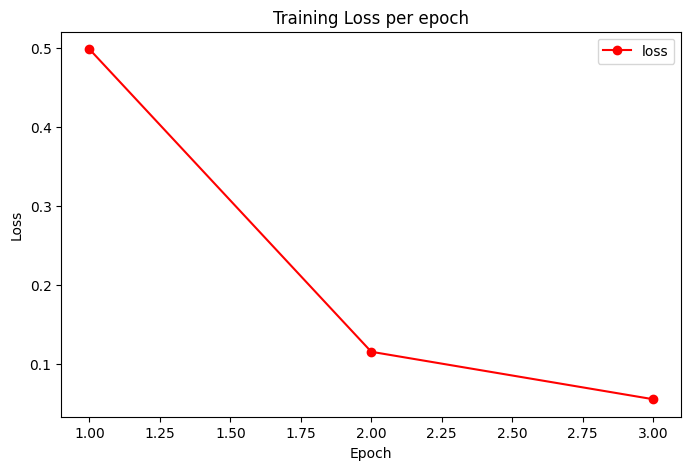

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8,5))
plt.plot(range(1, len(losses)+1), losses, marker='o', color='red', label='loss')
plt.title('Training Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid=True
plt.show()

In [42]:
model.eval()

with torch.no_grad():
    correct = 0.0
    total = 0.0
    for batch in test_loader:
        input = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        pred = model(input)
        loss = criterion(pred, labels)

        preds = torch.argmax(pred, dim=1)
        correct += (preds == labels).sum().item()
        total+= labels.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 97.70


In [43]:
torch.save(model.state_dict, "lstm_fakenews.pth")